# Proyek Klasifikasi Gambar: Intel Image Classification
- **Nama:** Muhammad Favian Zaahir
- **Email:** favianzaahir@gmail.com
- **ID Dicoding:** MS058D5Y0648

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Data Preparation

### Data Loading

In [2]:
train_dir = 'seg_train/seg_train'
validation_dir = 'seg_test/seg_test'
test_dir = 'seg_pred'

### Data Preprocessing

#### Split Dataset

In [3]:
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
    )
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
    )

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
    )

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
    )

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Classes\n")
for key, value in labels.items():
    print(f"{value}")

Classes

buildings
forest
glacier
mountain
sea
street


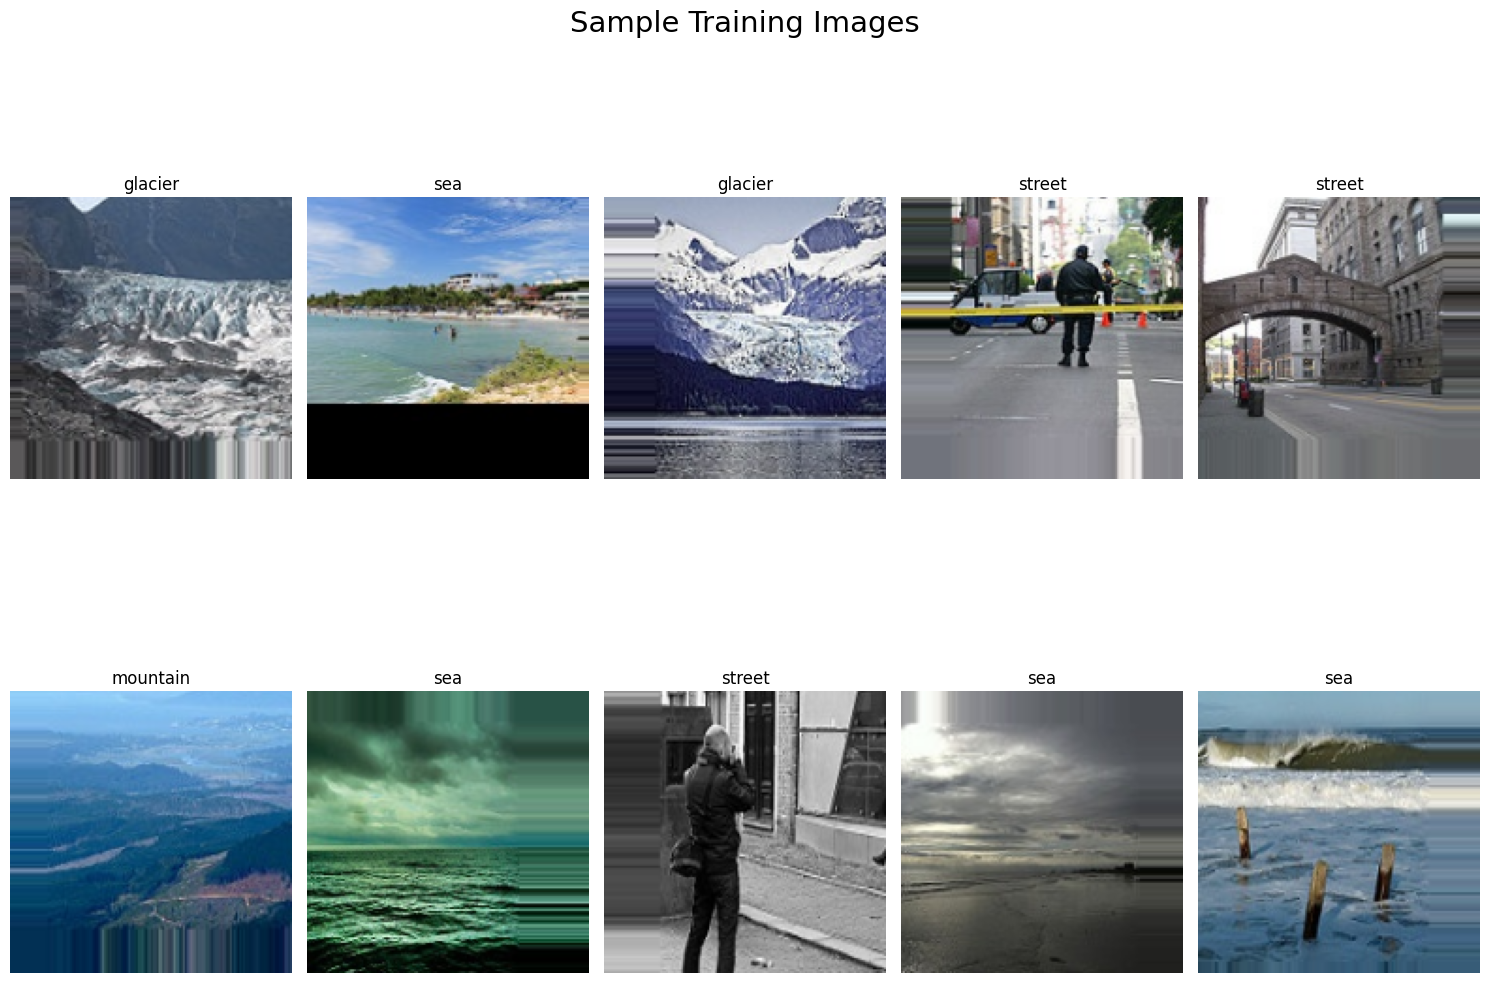

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

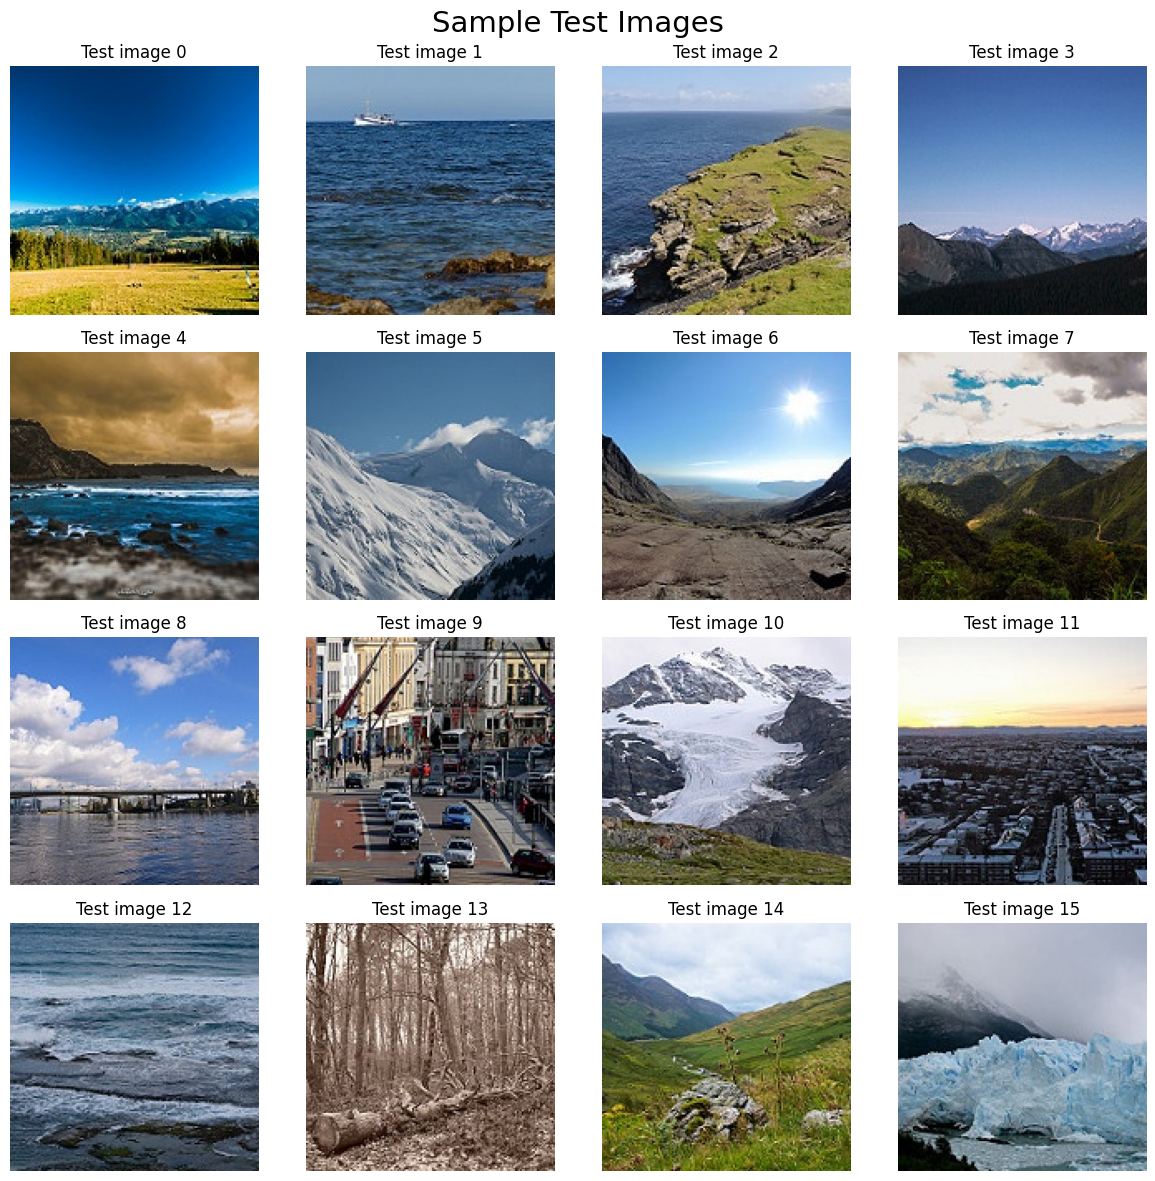

In [ ]:
plt.figure(figsize=(12,12))

images = next(test_generator)
for i in range(min(16, len(images))):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Test image {i}")
    
    plt.axis('off')
        
plt.suptitle("Sample Test Images", fontsize=21)
plt.tight_layout()
plt.show()

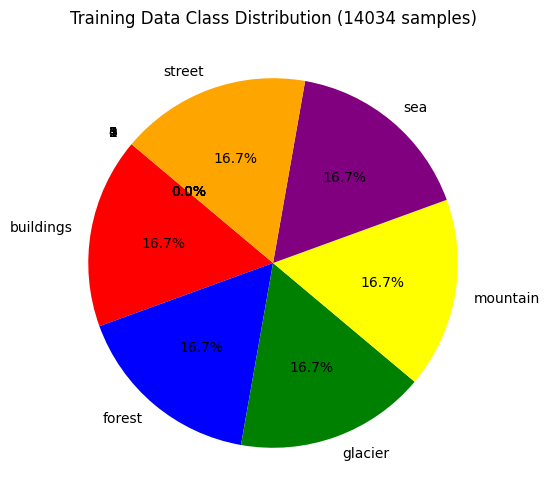

In [ ]:
def get_class_counts_from_generator(generator):
    class_counts = {v: 0 for k, v in generator.class_indices.items()}
    total_samples = generator.samples
    for class_name, count in zip(generator.class_indices.keys(), generator.classes):
        class_counts[class_name] = np.sum(generator.classes == count)
    return class_counts, total_samples

train_class_counts, train_total_samples = get_class_counts_from_generator(train_generator)

plt.figure(figsize=(8, 6))
plt.pie(train_class_counts.values(),
        labels=train_class_counts.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=['red', 'blue', 'green', 'yellow', 'purple', 'orange'])
plt.title(f'Training Data Class Distribution ({train_total_samples} samples)')
plt.show()

## Modelling

In [17]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=6, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 146, 146, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 35, 35, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 33, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,201,830 (8.40 MB)

 Trainable params: 2,201,382 (8.40 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),
    patience=5
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
    )

In [27]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[reduce_lr]
    )

Epoch 1/50
439/439 - 221s - 504ms/step - accuracy: 0.5941 - loss: 1.1288 - val_accuracy: 0.6833 - val_loss: 0.8317 - learning_rate: 1.0000e-03
Epoch 2/50
439/439 - 220s - 502ms/step - accuracy: 0.6595 - loss: 0.9346 - val_accuracy: 0.5077 - val_loss: 1.4091 - learning_rate: 1.0000e-03
Epoch 3/50
439/439 - 236s - 538ms/step - accuracy: 0.6961 - loss: 0.8445 - val_accuracy: 0.5897 - val_loss: 1.0083 - learning_rate: 1.0000e-03
Epoch 4/50
439/439 - 215s - 491ms/step - accuracy: 0.7212 - loss: 0.7800 - val_accuracy: 0.5637 - val_loss: 1.7921 - learning_rate: 1.0000e-03
Epoch 5/50
439/439 - 214s - 488ms/step - accuracy: 0.7395 - loss: 0.7338 - val_accuracy: 0.5873 - val_loss: 1.5768 - learning_rate: 1.0000e-03
Epoch 6/50
439/439 - 220s - 501ms/step - accuracy: 0.7554 - loss: 0.7036 - val_accuracy: 0.2880 - val_loss: 9.3546 - learning_rate: 1.0000e-03
Epoch 7/50
439/439 - 223s - 508ms/step - accuracy: 0.7886 - loss: 0.5977 - val_accuracy: 0.8403 - val_loss: 0.4741 - learning_rate: 3.1623e-04

## Evaluasi dan Visualisasi

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')

Found 3000 images belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.8957 - loss: 0.3063
Test accuracy: 88.67%


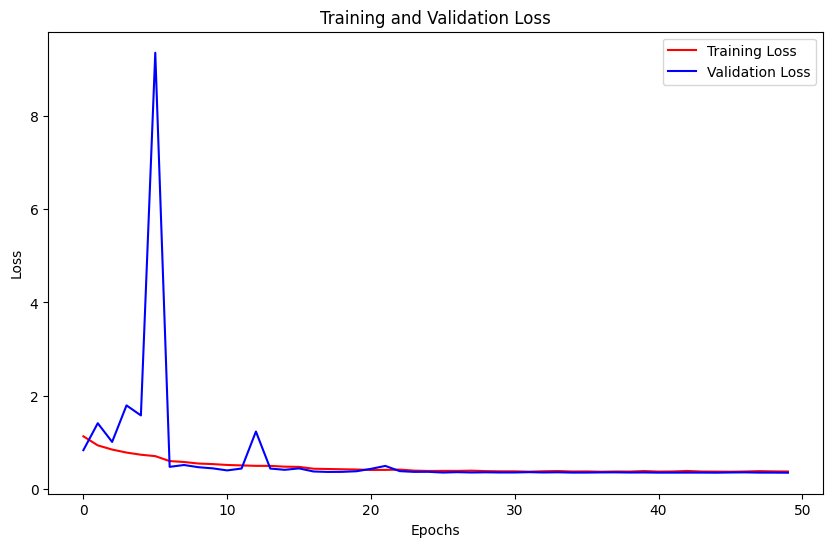

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

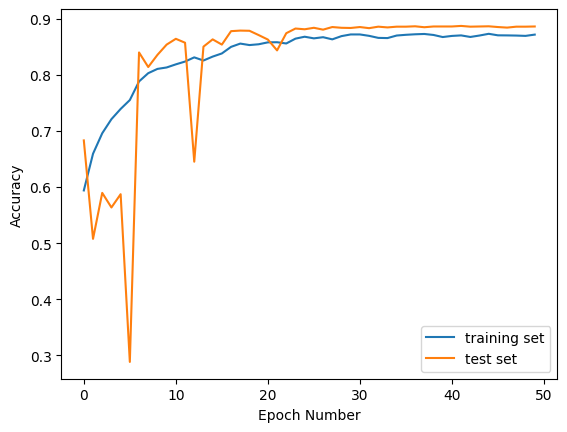

In [31]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [41]:
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

cr = classification_report(true_classes, predicted_classes, 
                          target_names=list(labels.values()))
print("Classification Report:")
print(cr)

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step
Classification Report:
              precision    recall  f1-score   support

   buildings       0.86      0.88      0.87       437
      forest       0.95      0.98      0.97       474
     glacier       0.84      0.85      0.85       553
    mountain       0.85      0.84      0.84       525
         sea       0.92      0.91      0.92       510
      street       0.90      0.87      0.89       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



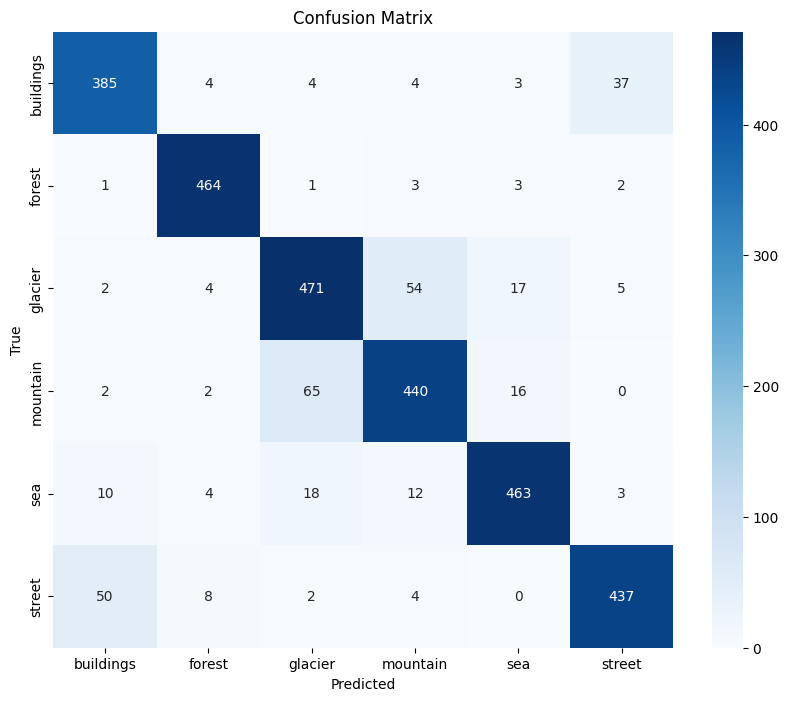

In [42]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(labels.values()),
            yticklabels=list(labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

In [ ]:
model.save('cnn_model.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
uploaded = files.upload()

In [ ]:
#this was ranned in gcolab since deprecated numpy in local
import tensorflowjs as tfjs

model_path = 'cnn_model.h5'
model = tf.keras.models.load_model(model_path)

output_dir = 'tfjs_model'
tfjs.converters.save_keras_model(model, output_dir)
print(f"Model saved to {output_dir}")

In [ ]:
!zip -r tfjs_model.zip tfjs_model

files.download('tfjs_model.zip')

In [ ]:
#this was also ranned in gcolab
model_path = 'cnn_model.keras'
model = tf.keras.models.load_model(model_path)

classes_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

saved_model_path = 'saved_model'
tf.saved_model.save(model, saved_model_path)
print(f"Model saved to {saved_model_path}")

In [ ]:
!zip -r saved_model.zip saved_model

files.download('saved_model.zip')

In [37]:
model = tf.keras.models.load_model('cnn_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TensorFlow Lite model saved to 'model.tflite'")

classes_names = list(labels.values())

with open('label.txt', 'w') as f:
    for label in classes_names:
        f.write(f"{label}\n")

INFO:tensorflow:Assets written to: C:\Users\favia\AppData\Local\Temp\tmp5wij36t8\assets


INFO:tensorflow:Assets written to: C:\Users\favia\AppData\Local\Temp\tmp5wij36t8\assets


Saved artifact at 'C:\Users\favia\AppData\Local\Temp\tmp5wij36t8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1778530515280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778575197968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778575198544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778575197008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778575198352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778575199696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778575198928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778928828880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778928830992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778928829072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  177892

## Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


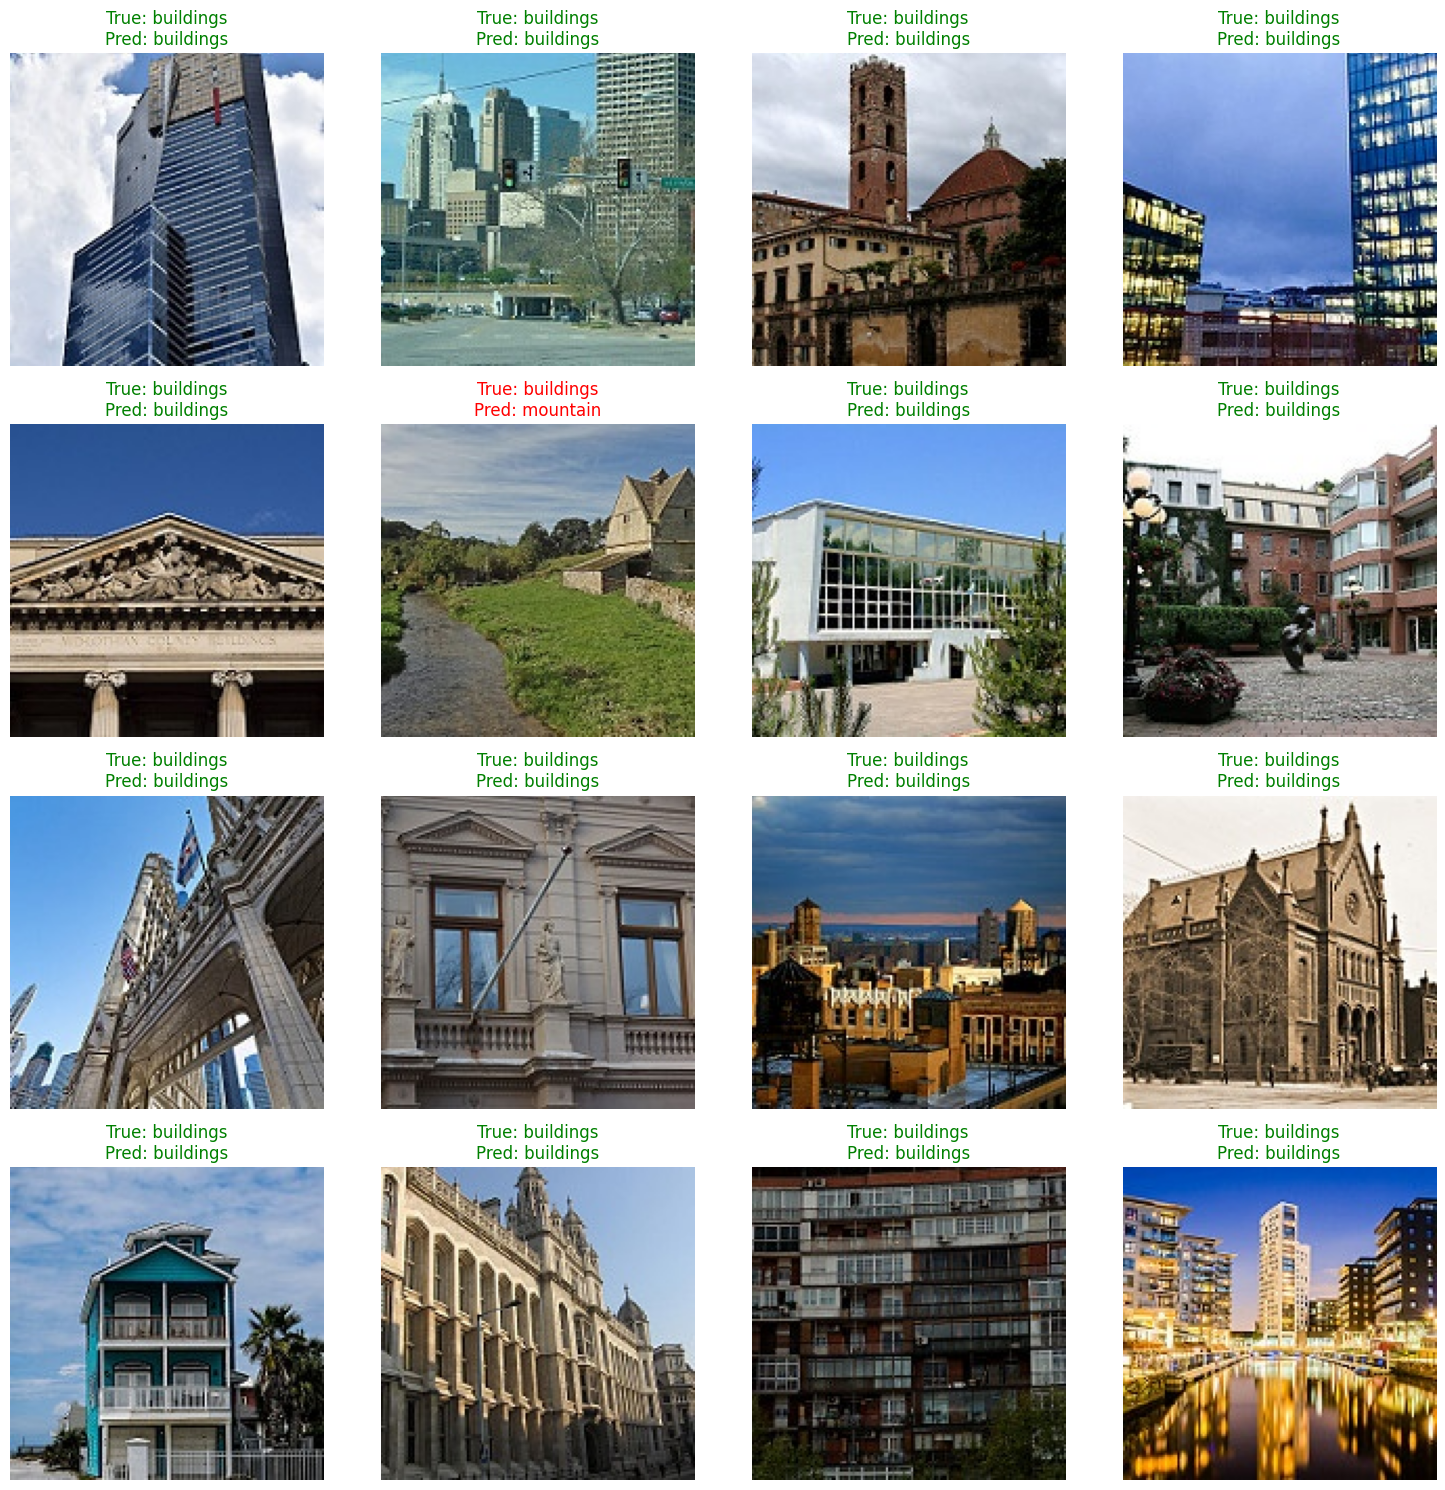

In [43]:
plt.figure(figsize=(15, 15))
test_generator.reset()
images, true_labels = next(test_generator)
predicted_labels = np.argmax(model.predict(images), axis=1)
true_labels = np.argmax(true_labels, axis=1)

for i in range(min(16, len(images))):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    is_correct = true_labels[i] == predicted_labels[i]
    color = "green" if is_correct else "red"
    plt.title(f"True: {labels[true_labels[i]]}\nPred: {labels[predicted_labels[i]]}", 
              color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()